In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import gridspec
import numpy as np  
from gcs import path_handler as ph
import gcs
import stream_analysis as sa
import pandas as pd

In [2]:
def extract_to_tail_coordinates(orbitpath,streampath,montecarlokey,internal_dynamics,NP):
    """
    Here to extract the raw data and transform the stream to tail coordinates in one go
    """

    time_of_interest,nDynTimes=0,2
    tOrb,xGCv,yGCv,zGCv,vxGCv,vyGCv,vzGCv = gcs.extractors.GCOrbits.extract_whole_orbit(orbitpath,montecarlokey=montecarlokey)
    tOrb,xGCv,yGCv,zGCv,vxGCv,vyGCv,vzGCv=sa.tailCoordinates.filter_orbit_by_dynamical_time(tOrb,xGCv,yGCv,zGCv,vxGCv,vyGCv,vzGCv,time_of_interest,nDynTimes)
    _,xp,yp,zp,vxp,vyp,vzp = gcs.extractors.Stream.extract_old_streams(streampath,internal_dynamics=internal_dynamics,montecarlokey=montecarlokey,NP=NP)
    xT,yT,zT,vxT,vyT,vzT,_ = sa.tailCoordinates.transform_from_galactico_centric_to_tail_coordinates(xp,yp,zp,vxp,vyp,vzp,tOrb,xGCv,yGCv,zGCv,vxGCv,vyGCv,vzGCv,t0=time_of_interest)
    return xT,yT,zT,vxT,vyT,vzT

In [3]:
GCname = "Pal5"
NP = int(1e5)
internal_dynamics = "isotropic-plummer"
montecarlokey="monte-carlo-030"
orbitPotential = "pouliasis2017pii-GCNBody"
streamPotential = "pouliasis2017pii-GCNBody"


In [4]:
orbitpath = ph.GC_orbits(MWpotential=orbitPotential,GCname=GCname)
streampath =ph.old_streams(MWpotential=streamPotential, GCname=GCname,montecarlokey=montecarlokey,NP=NP)
xT,yT,zT,vxT,vyT,vzT=extract_to_tail_coordinates(orbitpath,streampath,montecarlokey,internal_dynamics,NP)

In [5]:
XX,YY,H=sa.plotters.binned_density.short_cut(NP,xT,yT,[-10,10],[-1,1])
H=sa.plotters.binned_density.normalize_density_by_particle_number(H,NP)

In [6]:
mcindex = montecarlokey.split("-")[-1]
title = "Sampling "+mcindex
cbarlabel=r"Density [$N_p/N$]"
normalScatterProperties = {
    "alpha":0.5, 
    "s":1,
    "cmap":'rainbow',
    "norm":colors.LogNorm(vmin=1e-5, vmax=1e-3)
    }
AXIS={
    "xlabel":"$x_{tail}$ [kpc]",
    "ylabel":"$y_{tail}$ [kpc]",
    "xlim":[-10,10],
    "ylim":[-0.5,0.5],
    "yticks": [0,0.5],
    "xticks": np.arange(-10,11,2),
    "yticks": np.arange(-0.4,0.5,0.2),
    "title":title,
}


In [7]:
# Configure Matplotlib to use LaTeX for text rendering
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",  # Use 'serif' or specify the exact font family
    "font.serif": ["Times New Roman"],  # Replace with the font used in your LaTeX document
    "axes.labelsize": 12,  # Font size for axis labels
    "font.size": 12,  # General font size
    "legend.fontsize": 12,  # Font size for legend
    "xtick.labelsize": 12,  # Font size for x-axis tick labels
    "ytick.labelsize": 12,  # Font size for y-axis tick labels
})

In [8]:
results_path=ph.paths['simulations'] + "/ImpactGeometry/pouliasis2017pii-GCNBody/Pal5"+"/AllImpactGeometryByHandAndEye.csv"
results = pd.read_csv(results_path)
withgap=results[results['gap_flag']]
gap_flag=results['gap_flag']
selected=withgap[withgap[gap_flag]['montecarlokey'] == montecarlokey]
selected

/tmp/ipykernel_885865/1203054938.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  selected=withgap[withgap[gap_flag]['montecarlokey'] == montecarlokey]


,impact_parameter,w_par,w_per,v_rel,alpha,Mass,rplum,T,tau,suspect,montecarlokey,target_number,gap_flag
152,0.074541,292.238080,286.655773,409.358800,1.418866,786149.570343,0.002874,-0.153406,0.030737,NGC2808,monte-carlo-030,2,True
153,0.163992,366.618219,149.185013,395.809407,0.529253,414363.118456,0.004192,-0.871591,0.038749,NGC5272,monte-carlo-030,3,True


In [9]:
from astropy import units as u
from astropy.constants import G
unitD = u.kpc
unitV = u.km/u.s
unitM = u.Msun
unitG = (unitD*unitV**2)/unitM
G=G.to(unitG).value
deltaP=G*2*selected['Mass']/(selected['impact_parameter']*selected['v_rel'])
print("flagged for gap")
for i in range(len(selected)):
    print(selected['suspect'].values[i],deltaP.values[i])
print("all suspects")
myselected = results[results['montecarlokey'] == montecarlokey]
for i in range(len(myselected)):
    deltaP=G*2*myselected['Mass'].values[i]/(myselected['impact_parameter'].values[i]*myselected['v_rel'].values[i])
    print(myselected['suspect'].values[i],deltaP)


flagged for gap
NGC2808 0.22161427170645023
NGC5272 0.054911632018435366
all suspects
NGC362 0.04385429720590985
NGC5286 0.09378265915697723
NGC2808 0.22161427170645023
NGC5272 0.054911632018435366
NGC7099 0.42595448741978575


In [10]:
arrowprops=dict(facecolor='red',edgecolor="white", width=2, headwidth=8)
notes = {
    "monte-carlo-000":[
        dict(text="NGC2808",xy=(5.1,-0.1),xytext=(0,0.2),arrowprops=arrowprops),
        dict(text="NGC5634",xy=(5.8,-0.1),xytext=(3,0.35),arrowprops=arrowprops),
        dict(text="FSR1758",xy=(9,-0.1),xytext=(7,0.3),arrowprops=arrowprops),
        ],
    "monte-carlo-001":[
        dict(text="NGC2808",xy=(5.3,-0.1),xytext=(0,0.2),arrowprops=arrowprops),
        ],
    "monte-carlo-002":[
        dict(text="NGC6715",xy=(-8.5,0.25),xytext=(-8,-0.4),arrowprops=arrowprops),
        ],
    "monte-carlo-003":[
        dict(text="NGC2808",xy=(5.7,-0.1),xytext=(0.5,0.2),arrowprops=arrowprops),
        ],
    "monte-carlo-004":[
        dict(text="NGC2808",xy=(5.1,-0.1),xytext=(0.5,0.2),arrowprops=arrowprops),
    ],
    "monte-carlo-005":[
        dict(text="NGC2808",xy=(5.1,-0.1),xytext=(0.5,0.3),arrowprops=arrowprops),
        dict(text="NGC7089",xy=(-6.8,0.15),xytext=(-6.5,-0.45),arrowprops=arrowprops),
    ],
    "monte-carlo-006":[
        dict(text="NGC2808",xy=(4.6,-0.1),xytext=(0.5,0.2),arrowprops=arrowprops),
        dict(text="NGC6656",xy=(3.1,-0.2),xytext=(-0.5,-0.45),arrowprops=arrowprops),
    ],
    "monte-carlo-007":[
        dict(text="NGC2808",xy=(5.2,-0.1),xytext=(0.5,0.2),arrowprops=arrowprops),
        dict(text="Pal10",xy=(7.6,-0.1),xytext=(8.0,0.35),arrowprops=arrowprops),
    ],
    "monte-carlo-008":[
        dict(text="NGC2808",xy=(5.1,-0.1),xytext=(0.5,0.2),arrowprops=arrowprops),
    ],
    "monte-carlo-009":[
        dict(text="NGC2808",xy=(4.9,-0.1),xytext=(0,0.2),arrowprops=arrowprops),
        dict(text="NGC7078",xy=(6.3,-0.1),xytext=(2,0.3),arrowprops=arrowprops),
        dict(text="NGC104",xy=(7.8,-0.1),xytext=(4,0.35),arrowprops=arrowprops),
        ],
    "monte-carlo-010":[
        dict(text="NGC2808",xy=(5.6,-0.1),xytext=(1,0.2),arrowprops=arrowprops),
        ],
    "monte-carlo-011":[
        dict(text="NGC6584",xy=(4.3,-0.1),xytext=(0.5,0.10),arrowprops=arrowprops),
        dict(text="NGC2808",xy=(5.4,-0.12),xytext=(7,0.3),arrowprops=arrowprops),
        ],
    "monte-carlo-012":[
        dict(text="NGC2808",xy=(5.3,-0.12),xytext=(0,0.3),arrowprops=arrowprops),
    ],
    "monte-carlo-013":[
        dict(text="NGC2808",xy=(5.1,-0.12),xytext=(0,0.3),arrowprops=arrowprops),
    ],
    "monte-carlo-014":[
        dict(text="NGC2808",xy=(4.9,-0.12),xytext=(0,0.3),arrowprops=arrowprops),
        dict(text="NGC6584",xy=(-5.0,0.03),xytext=(-4.5,-0.35),arrowprops=arrowprops),
    ],
    "monte-carlo-015":[
        dict(text="NGC2808",xy=(5.2,-0.12),xytext=(0,0.3),arrowprops=arrowprops),
    ],
    "monte-carlo-016":[
        dict(text="NGC2808",xy=(5.2,-0.12),xytext=(0,0.3),arrowprops=arrowprops),
    ],
    "monte-carlo-017":[
        dict(text="NGC2808",xy=(4.9,-0.12),xytext=(0,0.3),arrowprops=arrowprops),
    ],
    "monte-carlo-018":[
        # dict(text="NGC104",xy=(3.0,0),xytext=(0,0.3),arrowprops=arrowprops),
    ],
    "monte-carlo-019":[
        dict(text="NGC2808",xy=(4.9,-0.12),xytext=(0,0.3),arrowprops=arrowprops),
        dict(text="NGC5824",xy=(6.1,-0.25),xytext=(7.5,0.35),arrowprops=arrowprops),
    ],
    "monte-carlo-020":[
        dict(text="NGC2808",xy=(4.9,-0.12),xytext=(0,0.3),arrowprops=arrowprops),
    ],
    "monte-carlo-021":[
        dict(text="NGC2808",xy=(5.3,-0.12),xytext=(0,0.3),arrowprops=arrowprops),
    ],
    "monte-carlo-022":[
        dict(text="NGC2808",xy=(5.5,-0.12),xytext=(8,0.35),arrowprops=arrowprops),
        dict(text="NGC6341",xy=(4.7,-0.12),xytext=(0,0.3),arrowprops=arrowprops),
    ],
    "monte-carlo-023":[
        dict(text="NGC2808",xy=(5.2,-0.12),xytext=(0,0.35),arrowprops=arrowprops),
    ],
    "monte-carlo-024":[
        dict(text="NGC6656",xy=(7.2,0.08),xytext=(7,0.55),arrowprops=arrowprops),
        dict(text="NGC2808",xy=(5.1,-0.12),xytext=(0,0.35),arrowprops=arrowprops),
    ],
    "monte-carlo-025":[
        dict(text="NGC5272",xy=(6.2,-0.08),xytext=(8,0.55),arrowprops=arrowprops),
        dict(text="NGC2808",xy=(5.1,-0.12),xytext=(-1.0,0.35),arrowprops=arrowprops),
    ],
    "monte-carlo-026":[
        dict(text="NGC3201",xy=(-4.8,0.05),xytext=(-7,-0.40),arrowprops=arrowprops),
        dict(text="NGC2808",xy=(6.2,-0.08),xytext=(3.0,0.15),arrowprops=arrowprops),
    ],
    "monte-carlo-027":[
        dict(text="NGC6341",xy=(-6.5,0.05),xytext=(-6,-0.40),arrowprops=arrowprops),
        dict(text="NGC2808",xy=(5.1,-0.15),xytext=(0.0,0.15),arrowprops=arrowprops),
        dict(text="NGC104",xy=(8.5,-0.08),xytext=(7.0,0.35),arrowprops=arrowprops),
    ],
    "monte-carlo-028":[
        dict(text="NGC2808",xy=(5.1,-0.15),xytext=(0.0,0.30),arrowprops=arrowprops),
        dict(text="NGC362",xy=(8.5,0.05),xytext=(7.0,0.40),arrowprops=arrowprops),
    ],
    "monte-carlo-029":[
        dict(text="NGC6584",xy=(3.1,-0.08),xytext=(0.0,0.30),arrowprops=arrowprops),
    ],
    "monte-carlo-030":[
        dict(text="NGC2808",xy=(5.0,-0.15),xytext=(0.0,0.15),arrowprops=arrowprops),
        dict(text="NGC5272",xy=(7.3,-0.04),xytext=(8.0,0.55),arrowprops=arrowprops),
    ],
    "monte-carlo-031":[
    ],
    "monte-carlo-032":[
        dict(text="NGC2808",xy=(5.3,-0.08),xytext=(0.0,0.15),arrowprops=arrowprops),
        # dict(text="IC1257",xy=(5.8,-0.20),xytext=(8.0,-0.45),arrowprops=arrowprops),
    ],
    "monte-carlo-033":[
        dict(text="NGC2808",xy=(4.9,-0.12),xytext=(0.0,0.15),arrowprops=arrowprops),
        dict(text="NGC5286",xy=(-5.9,0.10),xytext=(-5.0,-0.45),arrowprops=arrowprops),
        dict(text="NGC6333",xy=(6.1,0.-0.3),xytext=(8.0,-0.45),arrowprops=arrowprops),
        dict(text="NGC5272",xy=(7.7,0.01),xytext=(5.5,0.35),arrowprops=arrowprops),
    ],
    "monte-carlo-034":[
        dict(text="NGC2808",xy=(5.5,-0.08),xytext=(2.0,0.25),arrowprops=arrowprops),
    ],
    "monte-carlo-035":[
        dict(text="NGC2808",xy=(5.5,-0.08),xytext=(2.0,0.25),arrowprops=arrowprops),
        dict(text="NGC7089",xy=(6.05,-0.08),xytext=(8.0,0.25),arrowprops=arrowprops),
    ],
    "monte-carlo-036":[
        dict(text="NGC2808",xy=(4.75,-0.08),xytext=(0.0,0.25),arrowprops=arrowprops),
    ],
    "monte-carlo-037":[
        dict(text="NGC2808",xy=(4.9,-0.15),xytext=(0.5,0.15),arrowprops=arrowprops),
    ],
    "monte-carlo-038":[
        dict(text="NGC2808",xy=(5.5,-0.08),xytext=(-0.5,0.25),arrowprops=arrowprops),
    ],
    "monte-carlo-039":[
        dict(text="NGC2808",xy=(5.5,-0.08),xytext=(-0.5,0.25),arrowprops=arrowprops),
    ],
    "monte-carlo-040":[
        dict(text="NGC2808",xy=(5.3,-0.08),xytext=(-0.5,0.25),arrowprops=arrowprops),
    ],
    "monte-carlo-041":[
        dict(text="NGC2808",xy=(4.8,-0.12),xytext=(-1.5,0.25),arrowprops=arrowprops),
    ],
    "monte-carlo-042":[
        dict(text="NGC2808",xy=(5.1,-0.12),xytext=(1.5,0.25),arrowprops=arrowprops),
        dict(text="NGC7089",xy=(-4.5,-0.02),xytext=(-7.5,-0.35),arrowprops=arrowprops),
    ],
    "monte-carlo-043":[
        dict(text="NGC2808",xy=(4.8,-0.12),xytext=(0,0.25),arrowprops=arrowprops),
    ],
    "monte-carlo-043":[
        dict(text="NGC2808",xy=(4.8,-0.12),xytext=(0,0.25),arrowprops=arrowprops),
    ],
    "monte-carlo-044":[
        dict(text="NGC2808",xy=(5.75,0),xytext=(7,0.55),arrowprops=arrowprops),
        dict(text="NGC6356",xy=(3.75,0),xytext=(0,0.3),arrowprops=arrowprops),
    ],
    "monte-carlo-045":[
    ],
    "monte-carlo-046":[
    ],
    "monte-carlo-047":[
        dict(text="NGC2808",xy=(4.7,-0.12),xytext=(0,0.25),arrowprops=arrowprops),
    ],
    "monte-carlo-048":[
        dict(text="NGC2808",xy=(4.7,-0.12),xytext=(0,0.25),arrowprops=arrowprops),
        dict(text="NGC7089",xy=(5.3,-0.12),xytext=(8,0.25),arrowprops=arrowprops),
        dict(text="NGC5272",xy=(-9.3,0.12),xytext=(-7,-0.35),arrowprops=arrowprops),
    ],
    "monte-carlo-049":[
        dict(text="NGC2808",xy=(5.5,-0.12),xytext=(0,0.25),arrowprops=arrowprops),
        dict(text="NGC7089",xy=(7.8,0.05),xytext=(6,0.375),arrowprops=arrowprops),
    ],

}


## The above is a valuable data set. What is the distribution of distances from the center?

In [17]:
notes['monte-carlo-000'][0]

{'text': 'NGC2808',
 'xy': (5.1, -0.1),
 'xytext': (0, 0.2),
 'arrowprops': {'facecolor': 'red',
  'edgecolor': 'white',
  'width': 2,
  'headwidth': 8}}

In [18]:
distance_from_center = []
for key in notes.keys():
    for impact in notes[key]:
        distance_from_center.append(impact['xy'][0])


In [42]:
threshold = 5.75
number_of_gaps_in_observed_porition=np.sum(np.abs(distance_from_center) < threshold)
number_of_gaps_in_observed_porition

np.int64(51)

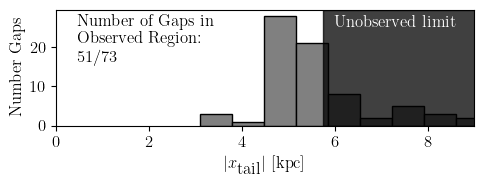

In [71]:
counts, bins = np.histogram(np.abs(distance_from_center),bins=20)
nbins = int(np.ceil(np.sqrt(len(distance_from_center))))
centers = (bins[:-1] + bins[1:]) / 2
xlims = [0,np.max(nbins)]
fig,axis=plt.subplots(1,1,figsize=(5,2))
axis.hist(np.abs(distance_from_center),bins=nbins,edgecolor='k',color='gray');
axis.set_xlabel(r"$|x_{\textrm{tail}}|$ [kpc]")
axis.set_ylabel("Number Gaps")
axis.axvspan(threshold, max(bins), color='k', alpha=0.75)
axis.set_xlim(xlims)
axis.text(0.05,0.55,"Number of Gaps in\n Observed Region: \n {:d}/{:d}".format(number_of_gaps_in_observed_porition,len(distance_from_center)),transform=axis.transAxes,ha='left')
axis.text(0.665,0.85,"Unobserved limit".format(threshold),transform=axis.transAxes,ha='left',color='white',fontsize=12,)
fig.tight_layout()
fig.savefig("../paper/GapWithinSight.png",dpi=300)

In [11]:
outdir = "../paper/"
filename = "gallery_of_gaps_"+montecarlokey+".png"

/tmp/ipykernel_73344/3454621057.py:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


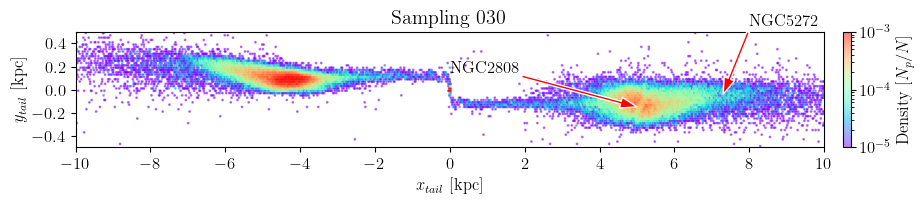

In [12]:
fig=plt.figure(figsize=(10,1.5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 0.01],wspace=0.05)
cbar=fig.add_subplot(gs[1])
axis=fig.add_subplot(gs[0])
im = axis.scatter(XX,YY,c=H,**normalScatterProperties)
axis.set(**AXIS);
cbar = plt.colorbar(im, cax=cbar)
cbar.set_label(cbarlabel)
for note in notes[montecarlokey]:
    axis.annotate(**note)
fig.tight_layout()
fig.savefig(outdir+filename,bbox_inches='tight',dpi=300)

In [13]:
def extract_tau(orbitpath,montecarlokey,streampath,internal_dynamics,NP):
    time_of_interest=0
    nDynTimes=2
    t,x,y,z,vx,vy,vz = gcs.extractors.GCOrbits.extract_whole_orbit(orbitpath,montecarlokey=montecarlokey)
    t,x,y,z,vx,vy,vz=sa.tailCoordinates.filter_orbit_by_dynamical_time(t,x,y,z,vx,vy,vz,time_of_interest,nDynTimes)
    _,xp,yp,zp,_,_,_ = gcs.extractors.Stream.extract_old_streams(streampath,internal_dynamics=internal_dynamics,montecarlokey=montecarlokey,NP=NP)
    indexes=sa.tailCoordinates.get_closests_orbital_index(x,y,z,xp,yp,zp)
    tau = t[indexes]
    return tau

In [96]:
vanillaPotential="pouliasis2017pii"
montecarlokey="monte-carlo-048"
orbitpathFULL = ph.GC_orbits(MWpotential=orbitPotential,GCname=GCname)
streampathFULL =ph.old_streams(MWpotential=streamPotential, GCname=GCname,montecarlokey=montecarlokey,NP=NP)
orbitpathVanilla = ph.GC_orbits(MWpotential=vanillaPotential,GCname=GCname)
streampathVanilla =ph.old_streams(MWpotential=vanillaPotential, GCname=GCname,montecarlokey=montecarlokey,NP=NP)

In [97]:
tauV = extract_tau(orbitpathVanilla,montecarlokey,streampathVanilla,internal_dynamics,NP)
tauF=extract_tau(orbitpathFULL,montecarlokey,streampathFULL,internal_dynamics,NP)

In [98]:
t,x,y,z,vx,vy,vz=gcs.extractors.GCOrbits.extract_whole_orbit(orbitpath,montecarlokey=montecarlokey)
todayindex = np.argmin(np.abs(t))
v = np.sqrt(vx**2+vy**2+vz**2)
taumin=-10/v[todayindex]
taumax=10/v[todayindex]

In [99]:
nbins=int(np.ceil(np.sqrt(NP)))
edges=np.linspace(taumin,taumax,nbins)
countsV,countsF=np.histogram(tauV,bins=edges)[0],np.histogram(tauF,bins=edges)[0]
centers = (edges[1:]+edges[:-1])/2


In [100]:
# do the smothing
box_length=7
N_APPlY=1
noise_factor=5
sigma=2
do_cross_correlation=True
centers,countsV,countsF=sa.density_profile_gap_detections.clean_up_stream_profiles(centers,countsV,countsF,box_length,N_APPlY,do_cross_correlation)
profiles=centers[box_length:-1-box_length],countsV[box_length:-1-box_length],countsF[box_length:-1-box_length]
noise_filtered_profiles,noiselevel,candidates=sa.density_profile_gap_detections.log_difference_detection(profiles,noise_factor,sigma)

Threshold for counts is 7


In [101]:
vanillaprop={
    "color":"black",
    "label":"Vanilla",
    "alpha":1,
}
fullprop={
    "color":"blue",
    "label":"Full",
    "alpha":1,
}



In [102]:
mcindex = montecarlokey.split("-")[-1]
title = "Sampling "+mcindex
myAXIS={
    "title":title,
    "xlabel":"$\\tau$ [s kpc/km]",
    "ylabel":"Counts",
    "xlim":[taumin,taumax],
    "yscale":"log",
    "ylim":[1,1e4],
}
hline={
    "y":noiselevel,
    "xmin":taumin,
    "xmax":taumax,
    "color":"black",
    "linestyle":"--",
    "label":"Noise Level"
}
vlines={
    "color":"red",
    "linestyle":"-",
    "label":"Candidates"
}

In [103]:
arrowprops=dict(facecolor='red',edgecolor="white", width=2, headwidth=8)
note={
    "monte-carlo-000":[
        dict(text="FSR1758",xy=(0.05,7e1),xytext=(0.03,1e1),arrowprops=arrowprops),
        ],
    "monte-carlo-002":[
        dict(text="NGC6715",xy=(-0.045,2e1),xytext=(-0.03,1e1),arrowprops=arrowprops),
        ],
    "monte-carlo-006":[
        dict(text="NGC6656",xy=(0.02,4e1),xytext=(0.034,1e1),arrowprops=arrowprops),
        ],
    "monte-carlo-008":[
        ],
    "monte-carlo-014":[
        ],
    "monte-carlo-018":[
        ],
    "monte-carlo-024":[
        dict(text="NGC6656",xy=(0.042,4e2),xytext=(0.034,1e1),arrowprops=arrowprops),
        ],
    "monte-carlo-025":[
        ],
    "monte-carlo-027":[
        ],
    "monte-carlo-028":[
        dict(text="NGC362",xy=(0.046,6e1),xytext=(0.024,1e1),arrowprops=arrowprops),        
        ],
    "monte-carlo-029":[
        dict(text="NGC6584",xy=(0.022,8e1),xytext=(0.034,1e1),arrowprops=arrowprops),        
        ],
    "monte-carlo-030":[
        dict(text="NGC5272",xy=(0.043,2e2),xytext=(0.024,1e1),arrowprops=arrowprops),        
        ],
    "monte-carlo-033":[
        ],
    "monte-carlo-044":[
        dict(text="NGC6356",xy=(0.025,2e2),xytext=(0.034,1e1),arrowprops=arrowprops),        
        ],
    "monte-carlo-048":[
        dict(text="NGC5272",xy=(-0.060,1e1),xytext=(-0.044,2e1),arrowprops=arrowprops),        
        dict(text="NGC7089",xy=(0.032,9e2),xytext=(0.024,2e1),arrowprops=arrowprops),        
        ],
      }


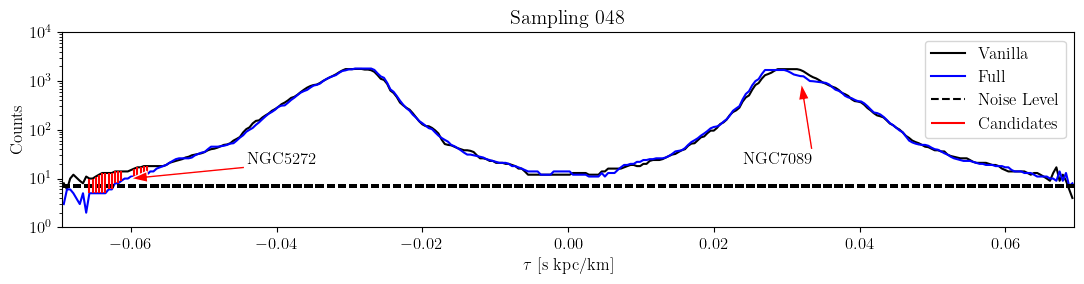

In [104]:
fig,axis=plt.subplots(1,1,figsize=(11,3))
axis.plot(centers,countsV,**vanillaprop)
axis.plot(centers,countsF,**fullprop)
axis.hlines(**hline)
axis.vlines(
    noise_filtered_profiles[0][candidates],
    noise_filtered_profiles[1][candidates],
    noise_filtered_profiles[2][candidates],
    **vlines
    )
for mynote in note[montecarlokey]:
    axis.annotate(**mynote)
axis.legend()
axis.set(**myAXIS);
fig.tight_layout()
fig.savefig("../paper/tau-profile-"+montecarlokey+".png",dpi=300)